In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt
import dask.dataframe as dd

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, EXAMPLE_FILES_from_LOCATIONS, EXAMPLE_FILES_to_FILEPATHS, EXAMPLE_FILES_to_DETECTIONS, FREQ_GROUPS
import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh

from cli import get_file_paths

In [18]:
def get_snr_from_band_limited_signal(band_limited_audio_seg, fs): 

    cleaned_call_signal = band_limited_audio_seg[int(fs*0.020):-int(fs*0.020)]
    signal = band_limited_audio_seg.copy()
    signal[:int(fs*0.02)] = 0
    signal[-int(fs*0.02):] = 0

    noise = band_limited_audio_seg - signal
    signal_power = np.square(cleaned_call_signal).mean()
    noise_power = np.square(noise).mean()
    snr = abs(10 * np.log10(signal_power / noise_power))

    return snr

def bandpass_audio_signal(audio_seg, fs, low_freq_cutoff, high_freq_cutoff):
    nyq = fs // 2
    low_cutoff = (low_freq_cutoff) / nyq
    high_cutoff =  (high_freq_cutoff) / nyq
    b, a = scipy.signal.butter(5, [low_cutoff, high_cutoff], btype='band', analog=False)
    band_limited_audio_seg = scipy.signal.filtfilt(b, a, audio_seg)

    return band_limited_audio_seg

def collect_call_snrs_from_bat_bout_in_audio_file(audio_file, bat_bout):
    fs = audio_file.samplerate
    nyquist = fs//2
    call_snrs = []
    for i, row in bat_bout.iterrows():
        start = row['start_time'] - 0.005
        end = row['start_time'] + 0.045
        if start >=0 and end <= 1795:
            duration = 0.05
            audio_file.seek(int(fs*start))
            audio_seg = audio_file.read(int(fs*duration))
            
            low_freq_cutoff = row['low_freq']-2000
            high_freq_cutoff = row['high_freq']+2000
            if high_freq_cutoff < nyquist:
                band_limited_audio_seg = bandpass_audio_signal(audio_seg, fs, low_freq_cutoff, high_freq_cutoff)
                snr = get_snr_from_band_limited_signal(band_limited_audio_seg, fs)
                call_snrs += [snr]
            else:
                call_snrs += [np.NaN]
        else:
            call_snrs += [np.NaN]

    return call_snrs


def get_bout_metrics_from_single_bd2_output(bd2_output, data_params, bout_params):
    batdetect2_predictions = ss.simulate_dutycycle_on_detections(bd2_output, data_params['cur_dc_tag'])
    batdetect2_preds_with_bouttags = bt_clustering.classify_bouts_in_bd2_predictions_for_freqgroups(batdetect2_predictions, bout_params)
    bout_metrics = bt_clustering.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)

    return bout_metrics

def gather_fft_spectra_for_calls_in_files(files, data_params, bout_params):
    bucket = []
    calls_sampled = pd.DataFrame()
    bout_index = 0
    for filepath_key in files:
        print(filepath_key)
        filename = filepath_key.split('/')[-1]
        file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
        audio_file = sf.SoundFile(file_path)
        fs = audio_file.samplerate

        csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
        bd2_predictions = dh.assemble_single_bd2_output(csv_path, data_params)
        bout_metrics = get_bout_metrics_from_single_bd2_output(bd2_predictions, data_params, bout_params)

        nyquist = fs//2
        for i, row in bout_metrics.iterrows():
            group = row['freq_group']
            freq_group = bd2_predictions.loc[bd2_predictions['freq_group']==group]
            bat_bout = freq_group.loc[(freq_group['start_time']>=row['start_time'])&(freq_group['end_time']<=row['end_time'])].copy()
            call_snrs = collect_call_snrs_from_bat_bout_in_audio_file(audio_file, bat_bout)

            bat_bout['SNR'] = call_snrs
            top_10_SNR =  0.90*bat_bout['SNR'].max()
            top_10_SNR_bat_bout = bat_bout.loc[bat_bout['SNR']>=top_10_SNR]
            bucket = collect_fft_spectra_from_calls_in_bout(audio_file, top_10_SNR_bat_bout, bucket)
            bat_bout_condensed = pd.DataFrame()
            bat_bout_condensed['bout_index'] = [bout_index]*len(top_10_SNR_bat_bout)
            bat_bout_condensed['SD Card'] = filepath_key.split('/')[0]
            bat_bout_condensed['File name'] = filename
            bat_bout_condensed['Site'] = top_10_SNR_bat_bout['Site name'].values
            bat_bout_condensed['SNR'] = top_10_SNR_bat_bout['SNR'].values

            calls_sampled = pd.concat([calls_sampled, bat_bout_condensed])
            bout_index += 1
            
    bucket = np.vstack(bucket)
    calls_sampled.reset_index(inplace=True)
    if 'index' in calls_sampled.columns:
        calls_sampled.drop(columns='index', inplace=True)
    return calls_sampled, bucket

In [19]:
def collect_fft_spectra_from_calls_in_bout(audio_file, bat_bout, bucket):
    fs = audio_file.samplerate
    nyq = fs//2

    for i, row in bat_bout.iterrows():

        start = row['start_time'] - 0.005
        end = row['start_time'] + 0.045
        if start >=0 and end <= 1795:
            duration = 0.05
            audio_file.seek(int(fs*start))
            audio_seg = audio_file.read(int(fs*duration))

            low_freq_cutoff = row['low_freq']-2000
            high_freq_cutoff = row['high_freq']+2000
            if high_freq_cutoff < nyq:
                band_limited_audio_seg = bandpass_audio_signal(audio_seg, fs, low_freq_cutoff, high_freq_cutoff)

                audio_spectrum = scipy.fft.rfft(band_limited_audio_seg)
                audio_spectrum = np.abs(audio_spectrum)
                audio_spectrum_db =  20*np.log10(audio_spectrum)
                normalized_audio_spectrum_db = audio_spectrum_db - audio_spectrum_db.max()

                thresh = -10
                peak_db = np.zeros(len(normalized_audio_spectrum_db))+thresh
                peak_db[normalized_audio_spectrum_db>=thresh] = normalized_audio_spectrum_db[normalized_audio_spectrum_db>=thresh]

                bucket.append(peak_db)

    return bucket

In [23]:
calls_sampled_from_all_locations = pd.DataFrame()
bucket_from_all_locations = []

# for site_key in FREQ_GROUPS.keys():
site_key = 'Foliage'
print(site_key)
freq_key = ''
data_params = dict()
data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = freq_key
data_params["cur_dc_tag"] = "1800of1800"
file_paths = get_file_paths(data_params)
location_sum_df = dh.assemble_initial_location_summary(data_params, file_paths) 
bout_params = bt_clustering.get_bout_params_from_location(location_sum_df, data_params)

Foliage


In [24]:
files = EXAMPLE_FILES_from_LOCATIONS[data_params['site_tag']]
# calls_sampled_from_location, bucket_from_location = gather_fft_spectra_for_calls_in_files(files, data_params, bout_params)
bucket = []
calls_sampled = pd.DataFrame()
bout_index = 0
# for filepath_key in files:
filepath_key = files[0]
print(filepath_key)
filename = filepath_key.split('/')[-1]
file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate

csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
bd2_predictions = dh.assemble_single_bd2_output(csv_path, data_params)
bout_metrics = get_bout_metrics_from_single_bd2_output(bd2_predictions, data_params, bout_params)

nyquist = fs//2
# for i, row in bout_metrics.iterrows():
i = 0
row = bout_metrics.iloc[i]
group = row['freq_group']
freq_group = bd2_predictions.loc[bd2_predictions['freq_group']==group]
bat_bout = freq_group.loc[(freq_group['start_time']>=row['start_time'])&(freq_group['end_time']<=row['end_time'])].copy()
call_snrs = collect_call_snrs_from_bat_bout_in_audio_file(audio_file, bat_bout)

bat_bout['SNR'] = call_snrs
top_10_SNR =  0.90*bat_bout['SNR'].max()
top_10_SNR_bat_bout = bat_bout.loc[bat_bout['SNR']>=top_10_SNR]
# bucket = collect_fft_spectra_from_calls_in_bout(audio_file, top_10_SNR_bat_bout, bucket)
fs = audio_file.samplerate
nyq = fs//2

# for i, row in bat_bout.iterrows():
i = 0
row = bat_bout.iloc[i]
start = row['start_time'] - 0.005
end = row['start_time'] + 0.045

UBNA_002/20220802_043000


In [55]:
if start >=0 and end <= 1795:
    duration = 0.05
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))

    low_freq_cutoff = row['low_freq']-2000
    high_freq_cutoff = row['high_freq']+2000
    if high_freq_cutoff < nyq:
        band_limited_audio_seg = bandpass_audio_signal(audio_seg, fs, low_freq_cutoff, high_freq_cutoff)

        audio_spectrum = scipy.fft.rfft(band_limited_audio_seg)
        audio_spectrum = np.abs(audio_spectrum)
        audio_spectrum_db =  20*np.log10(audio_spectrum)
        normalized_audio_spectrum_db = audio_spectrum_db - audio_spectrum_db.max()

        thresh = -10
        peak_db = np.zeros(int(duration*fs/2))+thresh
        peak_db[normalized_audio_spectrum_db>=thresh] = normalized_audio_spectrum_db[normalized_audio_spectrum_db>=thresh]

        # bucket.append(peak_db)
peak_db

IndexError: boolean index did not match indexed array along dimension 0; dimension is 4800 but corresponding boolean dimension is 4801

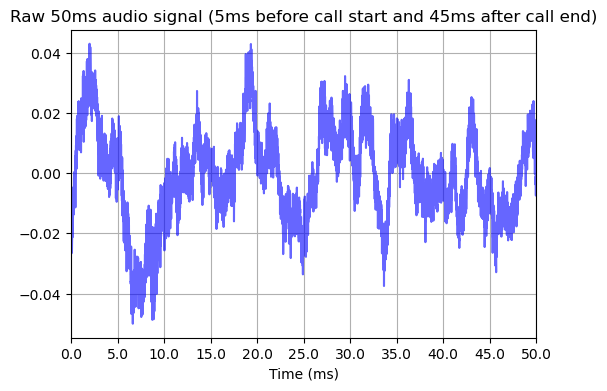

In [49]:
plt.figure(figsize=(6, 4))

plt.title('Raw 50ms audio signal (5ms before call start and 45ms after call end)')
plt.plot(audio_seg, color='blue', alpha=0.6)
plt.xticks(np.linspace(0, (duration*fs), 11).astype('int'), np.linspace(0, 1000*duration, 11).astype('float'))
plt.xlim(0, fs*duration)
plt.xlabel('Time (ms)')
plt.grid(which='both')
plt.show()

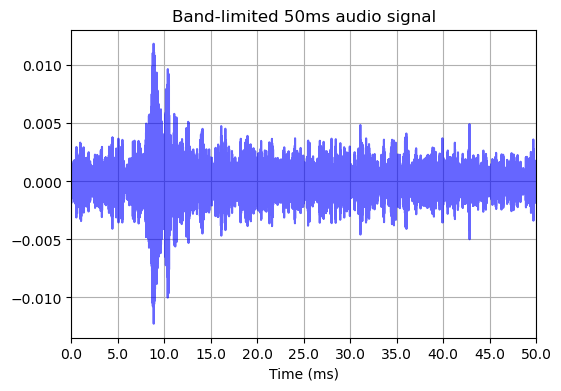

In [66]:
plt.figure(figsize=(6, 4))

plt.title('Band-limited 50ms audio signal')
plt.plot(band_limited_audio_seg, color='blue', alpha=0.6)
plt.xticks(np.linspace(0, (duration*fs), 11).astype('int'), np.linspace(0, 1000*duration, 11).astype('float'))
plt.xlim(0, fs*duration)
plt.xlabel('Time (ms)')
plt.grid(which='both')
plt.show()

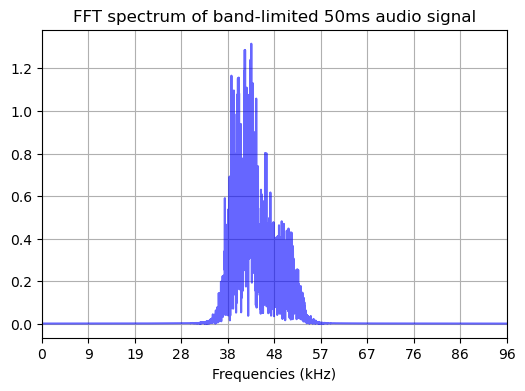

In [65]:
plt.figure(figsize=(6, 4))

plt.title('FFT spectrum of band-limited 50ms audio signal')
plt.plot(audio_spectrum, color='blue', alpha=0.6)
plt.xticks(np.linspace(0, duration*(fs/2), 11).astype('int'), np.linspace(0, fs/2000, 11).astype('int'))
plt.xlim(0, duration*fs/2)
plt.xlabel('Frequencies (kHz)')
plt.grid(which='both')
plt.show()

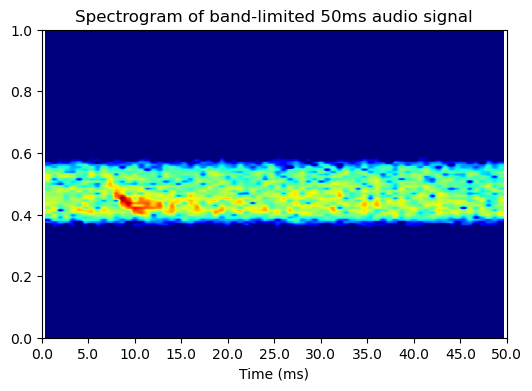

In [76]:
plt.figure(figsize=(6, 4))

vmin = 20*np.log10(np.max(band_limited_audio_seg)) - 40 # hide anything below -rm_dB dB
plt.title('Spectrogram of band-limited 50ms audio signal')
plt.specgram(band_limited_audio_seg, cmap='jet', vmin=vmin)
plt.xticks(np.linspace(0, (duration*fs/2), 11).astype('int'), np.linspace(0, 1000*duration, 11).astype('float'))
plt.xlim(0, fs/2*duration)
plt.xlabel('Time (ms)')
plt.show()

In [21]:
bucket = np.vstack(bucket)
bucket.shape

(2, 4801)

In [ ]:
bat_bout_condensed = pd.DataFrame()
bat_bout_condensed['bout_index'] = [bout_index]*len(top_10_SNR_bat_bout)
bat_bout_condensed['SD Card'] = filepath_key.split('/')[0]
bat_bout_condensed['File name'] = filename
bat_bout_condensed['Site'] = top_10_SNR_bat_bout['Site name'].values
bat_bout_condensed['SNR'] = top_10_SNR_bat_bout['SNR'].values

calls_sampled = pd.concat([calls_sampled, bat_bout_condensed])
bout_index += 1


In [ ]:
        
bucket = np.vstack(bucket)
calls_sampled.reset_index(inplace=True)
if 'index' in calls_sampled.columns:
    calls_sampled.drop(columns='index', inplace=True)

In [ ]:

calls_sampled_from_all_locations = pd.concat([calls_sampled_from_all_locations, calls_sampled_from_location])
bucket_from_all_locations.append(bucket_from_location)

In [9]:
bucket_from_all_locations = np.vstack(bucket_from_all_locations)

In [10]:
calls_sampled_from_all_locations

,bout_index,SD Card,File name,Site,SNR
0,0,UBNA_002,20220802_043000,Foliage,10.733231
1,0,UBNA_002,20220802_043000,Foliage,9.688971
2,1,UBNA_002,20220802_043000,Foliage,10.248171
3,2,UBNA_002,20220802_043000,Foliage,5.801648
4,3,UBNA_002,20220802_043000,Foliage,9.536065
...,...,...,...,...,...
1217,922,UBNA_002,20220802_093000,Foliage,5.093384
1218,923,UBNA_002,20220802_093000,Foliage,10.831970
1219,924,UBNA_002,20220802_093000,Foliage,6.527337
1220,925,UBNA_002,20220802_093000,Foliage,11.785258


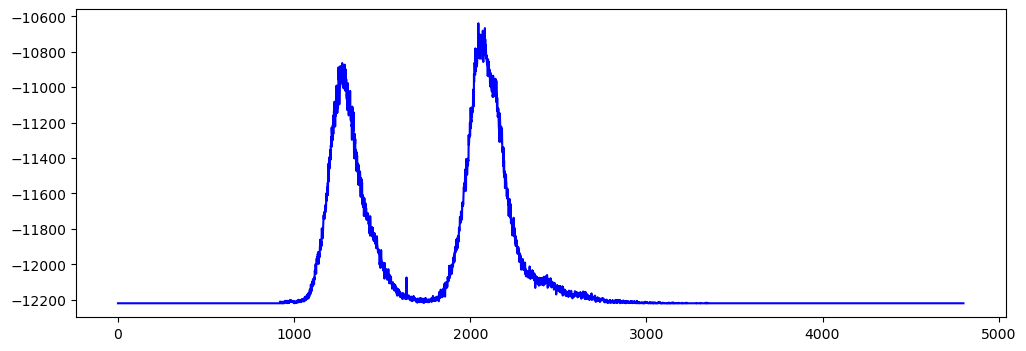

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(np.sum(bucket_from_all_locations, axis=0), color='blue', alpha = 1)
plt.show()